In [ ]:
!pip install -q scikit-learn matplotlib seaborn

## Импорт библиотек

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## Подключение Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Путь к данным

In [ ]:
DATA_PATH = r'/content/drive/MyDrive/ML project/CarImages'


## Конфигурация модели

In [ ]:
CONFIG = {
    'img_size': (224, 224),
    'batch_size': 16,
    'epochs': 40,
    'learning_rate': 1e-4,
    'random_seed': 42,
    'train_split': 0.7,
    'val_split': 0.15,
    'test_split': 0.15,
    'classes': ['audi', 'bentley', 'bmw', 'porsche', 'toyota'],
    'weight_decay': 1e-4  # Added weight_decay
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Установка случайного зерна

In [ ]:
np.random.seed(CONFIG['random_seed'])
torch.manual_seed(CONFIG['random_seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG['random_seed'])

## Функция анализа датасета

In [ ]:
def analyze_dataset(data_path):
    class_counts = {}
    total_images = 0

    for class_name in CONFIG['classes']:
        class_path = os.path.join(data_path, class_name)
        if os.path.exists(class_path):
            count = len([f for f in os.listdir(class_path)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = count
            total_images += count
            print(f"{class_name:10} : {count:5} изображений")

    print(f"{'ВСЕГО':10} : {total_images:5} изображений")
    return class_counts

class_distribution = analyze_dataset(DATA_PATH)

audi       :   556 изображений
bentley    :   564 изображений
bmw        :   480 изображений
porsche    :   471 изображений
toyota     :   552 изображений
ВСЕГО      :  2623 изображений


In [ ]:
def load_and_split_data(data_path):
    all_images = []
    all_labels = []
    class_to_idx = {class_name: idx for idx, class_name in enumerate(CONFIG['classes'])}
    for class_name in CONFIG['classes']:
        class_path = os.path.join(data_path, class_name)
        if os.path.exists(class_path):
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_name)
                    all_images.append(img_path)
                    all_labels.append(class_to_idx[class_name])

    # Разделение на train и val+test
    train_images, temp_images, train_labels, temp_labels = train_test_split(
        all_images, all_labels,
        test_size=CONFIG['val_split'] + CONFIG['test_split'],
        random_state=CONFIG['random_seed'],
        stratify=all_labels
    )
    # Разделение temp на val и test
    val_images, test_images, val_labels, test_labels = train_test_split(
        temp_images, temp_labels,
        test_size=0.5,
        random_state=CONFIG['random_seed'],
        stratify=temp_labels
    )
    print(f"\nРазделение завершено:")
    print(f"Train: {len(train_images)} изображений")
    print(f"Val: {len(val_images)} изображений")
    print(f"Test: {len(test_images)} изображений")
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

train_data, val_data, test_data = load_and_split_data(DATA_PATH)



Разделение завершено:
Train: 1836 изображений
Val: 393 изображений
Test: 394 изображений


In [ ]:
class CarDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        return {
            'pixel_values': image,
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

## Аугментация и нормализация для train

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.Resize(CONFIG['img_size']),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    normalize,
])

val_test_transforms = transforms.Compose([
    transforms.Resize(CONFIG['img_size']),
    transforms.ToTensor(),
    normalize,
])

## Создание DataLoaders

In [ ]:
train_dataset = CarDataset(train_data[0], train_data[1], train_transforms)
val_dataset = CarDataset(val_data[0], val_data[1], val_test_transforms)
test_dataset = CarDataset(test_data[0], test_data[1], val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2, pin_memory=True)


## Строим модель ResNet50

In [ ]:
def build_resnet_model():
    # Загрузка предобученной ResNet50
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

    # Заморозка всех слоев
    for param in model.parameters():
        param.requires_grad = False

    # Замена последнего слоя (классификатора)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(CONFIG['classes'])) # Fixed: Use len(CONFIG['classes']) instead of CONFIG['num_labels']
    return model

resnet_model = build_resnet_model()
resnet_model.to(device)

# Подсчет параметров
total_params = sum(p.numel() for p in resnet_model.parameters())
trainable_params = sum(p.numel() for p in resnet_model.parameters() if p.requires_grad)
print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров (только голова): {trainable_params:,}")
print(f"Замороженных параметров: {total_params - trainable_params:,}")


Всего параметров: 23,518,277
Обучаемых параметров (только голова): 10,245
Замороженных параметров: 23,508,032


## Функции обучения и валидации

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device, scaler):
    """Обучение на одной эпохе"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(dataloader, desc='Training')
    for batch in pbar:
        pixel_values = batch['pixel_values'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(pixel_values)
            loss = criterion(outputs, labels) # Ручной подсчет loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix({'loss': running_loss/len(dataloader), 'acc': correct/total})
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
def validate_epoch(model, dataloader, criterion, device):
    """Валидация на эпохе"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for batch in pbar:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(pixel_values)
            loss = criterion(outputs, labels) # Ручной подсчет loss
            running_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            pbar.set_postfix({'loss': running_loss/len(dataloader), 'acc': correct/total})
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

## ЭТАП 1: Обучение с замороженными слоями

In [ ]:
optimizer = torch.optim.AdamW(resnet_model.fc.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)


In [ ]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
patience = 15
patience_counter = 0

In [ ]:
for epoch in range(15):
    print(f"\nЭпоха {epoch+1}/15")
    train_loss, train_acc = train_epoch(resnet_model, train_loader, optimizer, criterion, device, scaler)
    val_loss, val_acc = validate_epoch(resnet_model, val_loader, criterion, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet_model.state_dict(), 'best_resnet_model_stage1.pth')
        print(f"Сохранена лучшая модель. Val Acc: {val_acc:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"\nEarly stopping на эпохе {epoch+1}")
        break

print(f"\nЭтап 1 завершен за {(time.time() - start_time)/60:.1f} мин")


Эпоха 1/15


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.68it/s, loss=1.29, acc=0.534]


Train Loss: 1.2550, Train Acc: 0.5659
Val Loss: 1.2914, Val Acc: 0.5344
Сохранена лучшая модель. Val Acc: 0.5344

Эпоха 2/15


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.60it/s, loss=1.28, acc=0.519]


Train Loss: 1.2471, Train Acc: 0.5752
Val Loss: 1.2754, Val Acc: 0.5191

Эпоха 3/15


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.71it/s, loss=1.26, acc=0.532]


Train Loss: 1.2251, Train Acc: 0.5817
Val Loss: 1.2633, Val Acc: 0.5318

Эпоха 4/15


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.73it/s, loss=1.25, acc=0.545]


Train Loss: 1.2174, Train Acc: 0.5861
Val Loss: 1.2472, Val Acc: 0.5445
Сохранена лучшая модель. Val Acc: 0.5445

Эпоха 5/15


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.58it/s, loss=1.25, acc=0.55]


Train Loss: 1.2135, Train Acc: 0.5822
Val Loss: 1.2497, Val Acc: 0.5496
Сохранена лучшая модель. Val Acc: 0.5496

Эпоха 6/15


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.60it/s, loss=1.24, acc=0.547]


Train Loss: 1.2041, Train Acc: 0.5866
Val Loss: 1.2414, Val Acc: 0.5471

Эпоха 7/15


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.44it/s, loss=1.23, acc=0.552]


Train Loss: 1.1946, Train Acc: 0.5893
Val Loss: 1.2254, Val Acc: 0.5522
Сохранена лучшая модель. Val Acc: 0.5522

Эпоха 8/15


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.52it/s, loss=1.23, acc=0.562]


Train Loss: 1.1785, Train Acc: 0.6008
Val Loss: 1.2261, Val Acc: 0.5623
Сохранена лучшая модель. Val Acc: 0.5623

Эпоха 9/15


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.40it/s, loss=1.22, acc=0.542]


Train Loss: 1.1704, Train Acc: 0.6275
Val Loss: 1.2244, Val Acc: 0.5420

Эпоха 10/15


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.74it/s, loss=1.2, acc=0.573]


Train Loss: 1.1616, Train Acc: 0.6078
Val Loss: 1.1993, Val Acc: 0.5725
Сохранена лучшая модель. Val Acc: 0.5725

Эпоха 11/15


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.67it/s, loss=1.19, acc=0.567]


Train Loss: 1.1577, Train Acc: 0.5986
Val Loss: 1.1867, Val Acc: 0.5674

Эпоха 12/15


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.19it/s, loss=1.19, acc=0.585]


Train Loss: 1.1444, Train Acc: 0.6111
Val Loss: 1.1935, Val Acc: 0.5852
Сохранена лучшая модель. Val Acc: 0.5852

Эпоха 13/15


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.62it/s, loss=1.19, acc=0.578]


Train Loss: 1.1279, Train Acc: 0.6296
Val Loss: 1.1920, Val Acc: 0.5776

Эпоха 14/15


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.77it/s, loss=1.18, acc=0.578]


Train Loss: 1.1317, Train Acc: 0.6187
Val Loss: 1.1772, Val Acc: 0.5776

Эпоха 15/15


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.64it/s, loss=1.16, acc=0.567]

Train Loss: 1.1259, Train Acc: 0.6231
Val Loss: 1.1620, Val Acc: 0.5674

Этап 1 завершен за 35.4 мин


## ЭТАП 2: Разморозка и тонкая настройка


In [ ]:
for param in resnet_model.layer4.parameters():
    param.requires_grad = True
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=CONFIG['learning_rate']/10, weight_decay=CONFIG['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

In [ ]:
trainable_params = sum(p.numel() for p in resnet_model.parameters() if p.requires_grad)
print(f"Обучаемых параметров (fine-tuning): {trainable_params:,}")


Обучаемых параметров (fine-tuning): 14,974,981


In [ ]:
remaining_epochs = CONFIG['epochs'] - 15
print(f"Обучение еще {remaining_epochs} эпох с размороженными слоями\n")

for epoch in range(remaining_epochs):
    print(f"\nЭпоха {epoch+16}/{CONFIG['epochs']}")
    train_loss, train_acc = train_epoch(resnet_model, train_loader, optimizer, criterion, device, scaler)
    val_loss, val_acc = validate_epoch(resnet_model, val_loader, criterion, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet_model.state_dict(), 'best_resnet_model_final.pth')
        print(f"Сохранена лучшая модель. Val Acc: {val_acc:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"\nEarly stopping на эпохе {epoch+16}")
        break

training_time = time.time() - start_time
print(f"\nОбучение завершено за {training_time/60:.2f} минут")


Обучение еще 25 эпох с размороженными слоями


Эпоха 16/40


Validation: 100%|██████████| 25/25 [00:04<00:00,  6.03it/s, loss=1.08, acc=0.608]


Train Loss: 1.0628, Train Acc: 0.6302
Val Loss: 1.0756, Val Acc: 0.6081
Сохранена лучшая модель. Val Acc: 0.6081

Эпоха 17/40


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.67it/s, loss=0.999, acc=0.641]


Train Loss: 0.9867, Train Acc: 0.6443
Val Loss: 0.9990, Val Acc: 0.6412
Сохранена лучшая модель. Val Acc: 0.6412

Эпоха 18/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.91it/s, loss=0.954, acc=0.649]


Train Loss: 0.8924, Train Acc: 0.6874
Val Loss: 0.9543, Val Acc: 0.6489
Сохранена лучшая модель. Val Acc: 0.6489

Эпоха 19/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.59it/s, loss=0.921, acc=0.669]


Train Loss: 0.8354, Train Acc: 0.7130
Val Loss: 0.9209, Val Acc: 0.6692
Сохранена лучшая модель. Val Acc: 0.6692

Эпоха 20/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.59it/s, loss=0.845, acc=0.692]


Train Loss: 0.7673, Train Acc: 0.7337
Val Loss: 0.8446, Val Acc: 0.6921
Сохранена лучшая модель. Val Acc: 0.6921

Эпоха 21/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.68it/s, loss=0.77, acc=0.715]


Train Loss: 0.7085, Train Acc: 0.7620
Val Loss: 0.7697, Val Acc: 0.7150
Сохранена лучшая модель. Val Acc: 0.7150

Эпоха 22/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.65it/s, loss=0.773, acc=0.712]


Train Loss: 0.6563, Train Acc: 0.7859
Val Loss: 0.7726, Val Acc: 0.7125

Эпоха 23/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.35it/s, loss=0.704, acc=0.738]


Train Loss: 0.6185, Train Acc: 0.7881
Val Loss: 0.7041, Val Acc: 0.7379
Сохранена лучшая модель. Val Acc: 0.7379

Эпоха 24/40


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.52it/s, loss=0.647, acc=0.756]


Train Loss: 0.5742, Train Acc: 0.8099
Val Loss: 0.6469, Val Acc: 0.7557
Сохранена лучшая модель. Val Acc: 0.7557

Эпоха 25/40


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.91it/s, loss=0.642, acc=0.763]


Train Loss: 0.5276, Train Acc: 0.8263
Val Loss: 0.6421, Val Acc: 0.7634
Сохранена лучшая модель. Val Acc: 0.7634

Эпоха 26/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.14it/s, loss=0.599, acc=0.781]


Train Loss: 0.5026, Train Acc: 0.8317
Val Loss: 0.5992, Val Acc: 0.7812
Сохранена лучшая модель. Val Acc: 0.7812

Эпоха 27/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.64it/s, loss=0.587, acc=0.781]


Train Loss: 0.4674, Train Acc: 0.8420
Val Loss: 0.5869, Val Acc: 0.7812

Эпоха 28/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.73it/s, loss=0.538, acc=0.804]


Train Loss: 0.4319, Train Acc: 0.8595
Val Loss: 0.5380, Val Acc: 0.8041
Сохранена лучшая модель. Val Acc: 0.8041

Эпоха 29/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.56it/s, loss=0.532, acc=0.814]


Train Loss: 0.4194, Train Acc: 0.8687
Val Loss: 0.5320, Val Acc: 0.8142
Сохранена лучшая модель. Val Acc: 0.8142

Эпоха 30/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.20it/s, loss=0.501, acc=0.824]


Train Loss: 0.3860, Train Acc: 0.8796
Val Loss: 0.5015, Val Acc: 0.8244
Сохранена лучшая модель. Val Acc: 0.8244

Эпоха 31/40


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.41it/s, loss=0.475, acc=0.832]


Train Loss: 0.3458, Train Acc: 0.8943
Val Loss: 0.4754, Val Acc: 0.8321
Сохранена лучшая модель. Val Acc: 0.8321

Эпоха 32/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.37it/s, loss=0.507, acc=0.814]


Train Loss: 0.3332, Train Acc: 0.8960
Val Loss: 0.5069, Val Acc: 0.8142

Эпоха 33/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.69it/s, loss=0.521, acc=0.817]


Train Loss: 0.3193, Train Acc: 0.8981
Val Loss: 0.5214, Val Acc: 0.8168

Эпоха 34/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.67it/s, loss=0.504, acc=0.812]


Train Loss: 0.2967, Train Acc: 0.9058
Val Loss: 0.5039, Val Acc: 0.8117

Эпоха 35/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.73it/s, loss=0.474, acc=0.827]


Train Loss: 0.2769, Train Acc: 0.9172
Val Loss: 0.4739, Val Acc: 0.8270

Эпоха 36/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.66it/s, loss=0.462, acc=0.84]


Train Loss: 0.2663, Train Acc: 0.9172
Val Loss: 0.4621, Val Acc: 0.8397
Сохранена лучшая модель. Val Acc: 0.8397

Эпоха 37/40


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.80it/s, loss=0.478, acc=0.824]


Train Loss: 0.2546, Train Acc: 0.9227
Val Loss: 0.4776, Val Acc: 0.8244

Эпоха 38/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.45it/s, loss=0.434, acc=0.842]


Train Loss: 0.2410, Train Acc: 0.9205
Val Loss: 0.4343, Val Acc: 0.8422
Сохранена лучшая модель. Val Acc: 0.8422

Эпоха 39/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.71it/s, loss=0.428, acc=0.855]


Train Loss: 0.2358, Train Acc: 0.9227
Val Loss: 0.4276, Val Acc: 0.8550
Сохранена лучшая модель. Val Acc: 0.8550

Эпоха 40/40


Validation: 100%|██████████| 25/25 [00:03<00:00,  7.92it/s, loss=0.453, acc=0.842]

Train Loss: 0.2430, Train Acc: 0.9232
Val Loss: 0.4529, Val Acc: 0.8422

Обучение завершено за 46.26 минут


In [ ]:
resnet_model.load_state_dict(torch.load('best_resnet_model_final.pth'))
resnet_model.eval()
print("\n=== ФИНАЛЬНАЯ ОЦЕНКА НА TEST SET ===")
all_predictions = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        outputs = resnet_model(pixel_values)
        predictions = torch.argmax(outputs, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_predictions)
test_f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")



=== ФИНАЛЬНАЯ ОЦЕНКА НА TEST SET ===


Testing: 100%|██████████| 25/25 [01:29<00:00,  3.59s/it]


Test Accuracy: 0.8579
Test F1-Score: 0.8551


In [ ]:
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(all_labels, all_predictions, target_names=CONFIG['classes']))


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        audi       0.75      0.94      0.83        84
     bentley       0.89      0.94      0.91        85
         bmw       0.98      0.62      0.76        72
     porsche       0.87      0.89      0.88        70
      toyota       0.89      0.87      0.88        83

    accuracy                           0.86       394
   macro avg       0.87      0.85      0.85       394
weighted avg       0.87      0.86      0.86       394



## Матрица ошибок

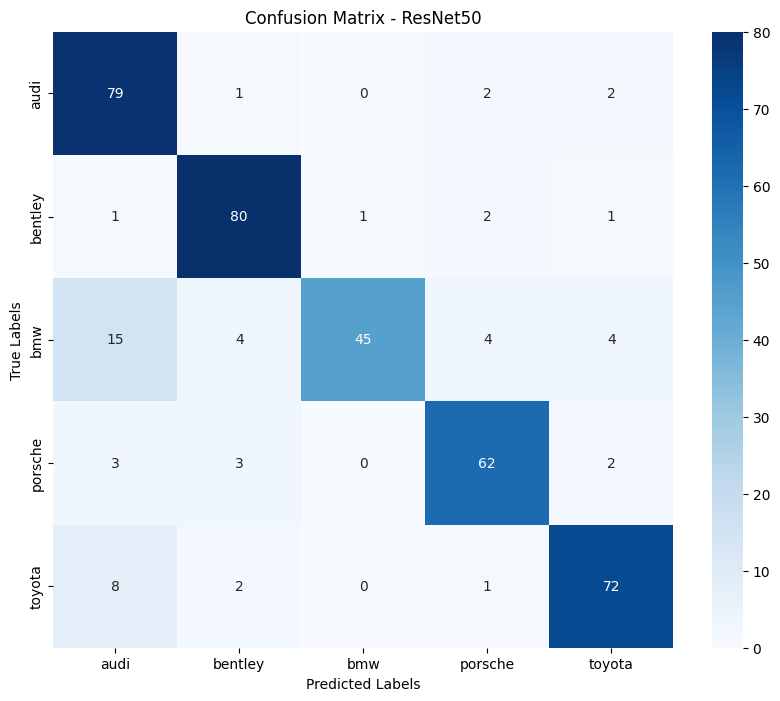

In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CONFIG['classes'],
            yticklabels=CONFIG['classes'])
plt.title('Confusion Matrix - ResNet50')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


## Визуализация обучения

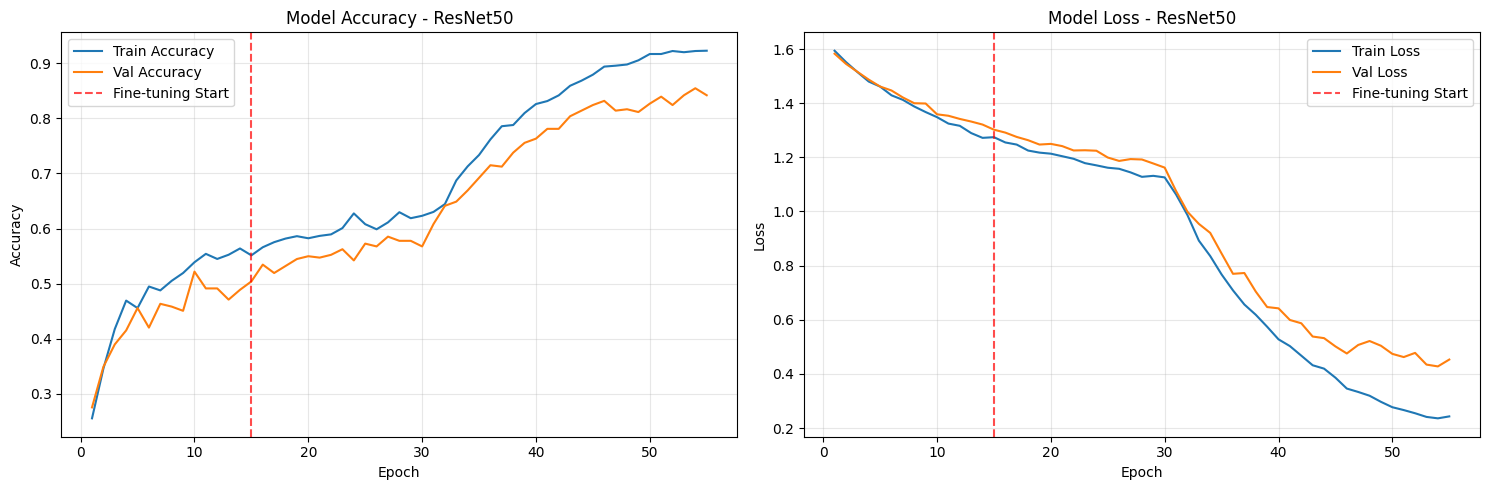

In [ ]:
def plot_training_history(history):
    epochs_range = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(15, 5))
    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs_range, history['val_acc'], label='Val Accuracy')
    plt.axvline(x=15, color='r', linestyle='--', alpha=0.7, label='Fine-tuning Start')
    plt.title('Model Accuracy - ResNet50')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Val Loss')
    plt.axvline(x=15, color='r', linestyle='--', alpha=0.7, label='Fine-tuning Start')
    plt.title('Model Loss - ResNet50')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
plot_training_history(history)

## Сохранение модели на Google Drive

In [ ]:
model_save_path = r'/content/drive/MyDrive/ML Project/resnet50_model.pth'
output_dir = os.path.dirname(model_save_path)
os.makedirs(output_dir, exist_ok=True)
torch.save(resnet_model.state_dict(), model_save_path)
print("Модель сохранена на Google Drive!")

Модель сохранена на Google Drive!


## Функция для предсказания

In [ ]:
def predict_car_brand(image_path, model, transforms, device):
    """Функция для предсказания марки автомобиля по изображению"""
    # Загрузка и обработка изображения
    image = Image.open(image_path).convert('RGB')
    pixel_values = transforms(image).unsqueeze(0).to(device)

    # Предсказание
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        predicted_class = torch.argmax(probabilities).item()
        confidence = probabilities[predicted_class].item()

    class_names = CONFIG['classes']
    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(image_path)) # Показываем оригинальное изображение
    plt.title(f"Predicted: {class_names[predicted_class]}\nConfidence: {confidence:.2%}")
    plt.axis('off')
    # График вероятностей
    plt.subplot(1, 2, 2)
    probs = probabilities.cpu().numpy()
    colors = ['green' if i == predicted_class else 'gray' for i in range(len(class_names))]
    plt.barh(class_names, probs, color=colors)
    plt.xlabel('Probability')
    plt.title('Class Probabilities')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

    return class_names[predicted_class], confidence


In [ ]:
print("\n=== МОДЕЛЬ ГОТОВА К ИСПОЛЬЗОВАНИЮ ===")


=== МОДЕЛЬ ГОТОВА К ИСПОЛЬЗОВАНИЮ ===
